In [1]:
from tensorflow import keras, TensorSpec
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.data import Dataset, experimental

import os

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# set "machine" according to where you want to run the script

machine = 'local' # 'colab' or 'local'

In [4]:
# load google drive when working on colab
if machine == 'colab':
    from google.colab import drive
    #drive.mount('/content/drive')
    drive.mount("/content/drive", force_remount=True)

In [4]:
# modelname: 

model_name = 'inceptionv3_01'

#####################################
# paths:
#####################################

if machine == 'local':
    # paths to load data:
    base_path = r"..\\data\\"
    base_path_in = os.path.join(base_path, "processed", "DL")   # path to read from the *.npy files

    # paths to save models:
    model_path = r"..\\Models\\local\\DL"

elif machine == 'colab':
    # paths to load data:
    base_path = '/content/drive/MyDrive/data'
    base_path_in = os.path.join(base_path, "processed")   # path to read from the *.npy files

    # paths to save models:
    model_path = '/content/drive/MyDrive/models/DL'

## load data option 1

In [10]:
# import numpy as np
import tensorflow as tf


# Paths to the .npy files for training and validation
train_images_file = os.path.join(base_path_in, 'X_traindl_with_masks.npy')
train_labels_file = os.path.join(base_path_in, 'y_traindl_with_masks.npy')
val_images_file = os.path.join(base_path_in, 'X_valdl_with_masks.npy')
val_labels_file = os.path.join(base_path_in, 'y_valdl_with_masks.npy')
test_images_file = os.path.join(base_path_in, 'X_testdl_with_masks.npy')
test_labels_file = os.path.join(base_path_in, 'y_testdl_with_masks.npy')

# Load the numpy arrays using memory mapping
X_train = np.load(train_images_file, mmap_mode='r')
y_train = np.load(train_labels_file, mmap_mode='r')
X_val = np.load(val_images_file, mmap_mode='r')
y_val = np.load(val_labels_file, mmap_mode='r')
X_test = np.load(test_images_file, mmap_mode='r')
y_test = np.load(test_labels_file, mmap_mode='r')

print("X_train:", X_train.shape) 
print("y_train:", y_train.shape) 
print("X_val:", X_val.shape) 
print("y_val:", y_val.shape) 
print("X_test:", X_test.shape) 
print("y_test:", y_test.shape) 


# Function to preprocess the images
def preprocess(image):
    image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB
    image = tf.image.resize(image, (299, 299))  # Ensure correct shape
    #image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image

# Function to create a dataset
def create_dataset(X, y):
    def generator():
        for i in range(X.shape[0]):
            yield preprocess(tf.convert_to_tensor(X[i], dtype=tf.float32)), tf.convert_to_tensor(y[i])

    dataset = tf.data.Dataset.from_generator(generator, 
                                             output_signature=(
                                                 tf.TensorSpec(shape=(299, 299, 3), dtype=tf.float32),
                                                 tf.TensorSpec(shape=(4,), dtype=tf.int32)  # Adjust dtype if necessary
                                             ))
    return dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Create training and validation datasets
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)


X_train: (21852, 299, 299, 1)
y_train: (21852, 4)
X_val: (5463, 299, 299, 1)
y_val: (5463, 4)
X_test: (3176, 64, 64, 1)
y_test: (3176, 4)


In [8]:
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)  # Should be (None, 299, 299, 3)
    print("Label shape:", label.shape)  # Should be (None, num_classes)


for image, label in val_ds.take(1):
    print("Image shape:", image.shape)  # Should be (None, 299, 299, 3)
    print("Label shape:", label.shape)  # Should be (None, num_classes)

for image, label in test_ds.take(1):
    print("Image shape:", image.shape)  # Should be (None, 299, 299, 3)
    print("Label shape:", label.shape)  # Should be (None, num_classes)

Image shape: (32, 299, 299, 3)
Label shape: (32, 4)
Image shape: (32, 299, 299, 3)
Label shape: (32, 4)
Image shape: (32, 299, 299, 3)
Label shape: (32, 4)


## Load data option 2


In [ ]:
# # Paths to numpy files
# x_train_path = os.path.join(base_path_in, 'X_traindl_with_masks.npy')
# y_train_path = os.path.join(base_path_in, 'y_traindl_with_masks.npy')
# x_val_path = os.path.join(base_path_in, 'X_valdl_with_masks.npy')
# y_val_path = os.path.join(base_path_in, 'y_valdl_with_masks.npy')

# # Define generator functions
# def data_generator_train():
#     X_train = np.load(x_train_path, mmap_mode='r')  # Memory-mapped loading (prevents excessive RAM usage)
#     y_train = np.load(y_train_path, mmap_mode='r')

#     for x, y in zip(X_train, y_train):
#         #np.repeat(X_train, 3, axis=-1)
#         x_rgb = np.repeat(x, 3, axis=-1)  # Convert grayscale to RGB
#         yield x_rgb.astype(np.float32), y  # Ensure correct dtype

# def data_generator_val():
#     X_val = np.load(x_val_path, mmap_mode='r')  # Memory-mapped loading (prevents excessive RAM usage)
#     y_val = np.load(y_val_path, mmap_mode='r')

#     for x, y in zip(X_val, y_val):
#         #np.repeat(X_val, 3, axis=-1)
#         x_rgb = np.repeat(x, 3, axis=-1)  # Convert grayscale to RGB
#         #x_resized = tf.image.resize(x_rgb, (299, 299))
#         yield x_rgb.astype(np.float32), y  # Ensure correct dtype

# # Define dataset
# output_signature = (
#     TensorSpec(shape=(299, 299, 3), dtype=np.float32),
#     TensorSpec(shape=(), dtype=np.int64)
# )

# train_ds = Dataset.from_generator(data_generator_train, output_signature=output_signature)
# train_ds = train_ds.batch(32).prefetch(experimental.AUTOTUNE)  # Optimized loading

# val_ds = Dataset.from_generator(data_generator_val, output_signature=output_signature)
# train_ds = train_ds.batch(32).prefetch(experimental.AUTOTUNE)  # Optimized loading


# # # Example: Iterate through dataset
# # for batch_x, batch_y in dataset.take(1):
# #     print(batch_x.shape, batch_y.shape)  # Shape of processed data



## loading data

In [ ]:
# # hier noch was anderes finden zum laden in batches
# # Sanyias Tipp: tf.data.Dataset 

# # generelll wundere ich mich, dass die Input-Daten schon flattend numpy arrays sind. in den beispielen werden immer bilder geladen.

# X_train = np.load(os.path.join(base_path_in,'X_traindl_with_masks.npy'))
# y_train = np.load(os.path.join(base_path_in, 'y_traindl_with_masks.npy'))
# X_val   = np.load(os.path.join(base_path_in,'X_valdl_with_masks.npy'))
# y_val   = np.load(os.path.join(base_path_in,'y_valdl_with_masks.npy'))
# X_test  = np.load(os.path.join(base_path_in,'X_testdl_with_masks.npy'))
# y_test  = np.load(os.path.join(base_path_in,'y_testdl_with_masks.npy'))

In [ ]:

# # Convert grayscale to 3-channel RGB
# # X_train = np.repeat(X_train, 3, axis=-1)
# # X_val   = np.repeat(X_val, 3, axis=-1)
# X_test  = np.repeat(X_test, 3, axis=-1)

In [ ]:
# # train_ds = Dataset.from_tensor_slices((X_train, y_train))
# # val_ds = Dataset.from_tensor_slices((X_val, y_val))
# test_ds = Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
# Batch the dataset
#batch_size = 32
# train_ds = train_ds.batch(batch_size)
# val_ds = val_ds.batch(batch_size)
#test_ds = test_ds.batch(batch_size)

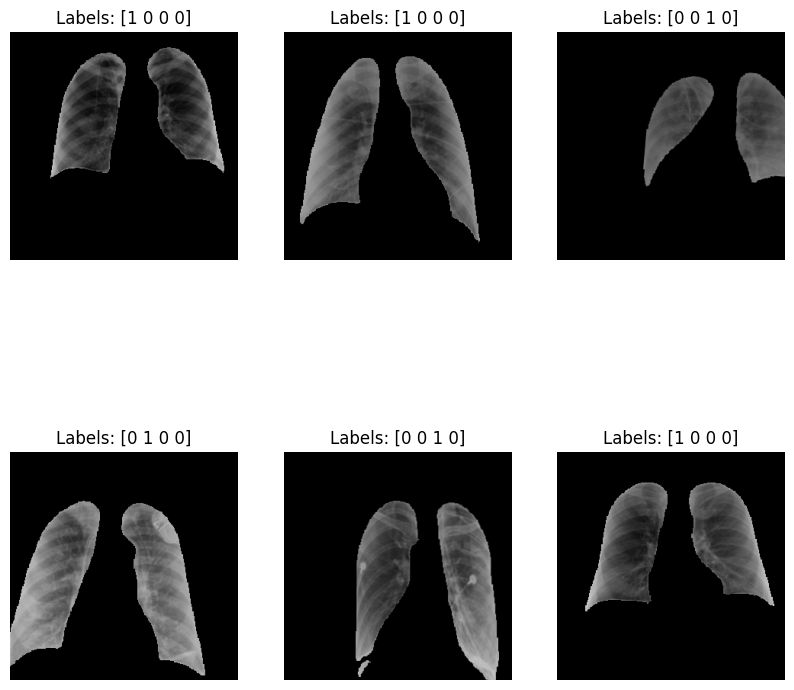

In [8]:
# Define the number of images to display
number_of_images = 6

# Create a figure for displaying
plt.figure(figsize=(10,10))

# Get a batch of images from train_ds
for batch, labels in train_ds.take(1):
    # Display the images from the batch
    for i in range(number_of_images):
        ax = plt.subplot(2, 3, i + 1) 
        plt.imshow(batch[i].numpy())  # Convert the image to integer for display
        plt.axis("off") 
        plt.title(f"Labels: {labels[i].numpy()}")  # Display the label of the image (+18 since our age data starts at 18 and labels start at 0)

# Show the images
plt.show()


In [9]:

# apply preprocessing

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
#test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.99338716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.9948635].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.9958672].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.99403304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.9939173].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.9935102].


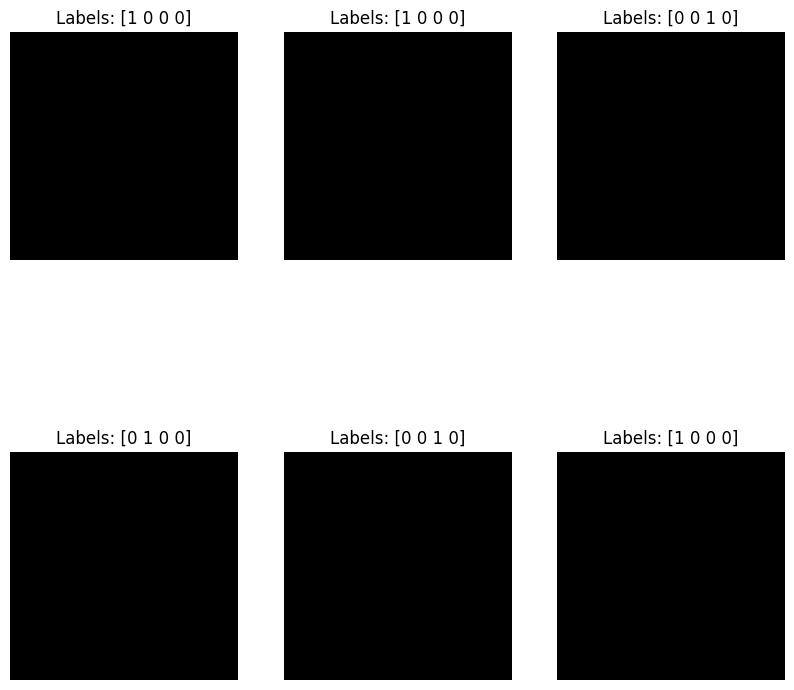

In [10]:
# Define the number of images to display
number_of_images = 6

# Create a figure for displaying
plt.figure(figsize=(10,10))

# Get a batch of images from train_ds
for batch, labels in train_ds.take(1):
    # Display the images from the batch
    for i in range(number_of_images):
        ax = plt.subplot(2, 3, i + 1) 
        plt.imshow(batch[i].numpy())  # Convert the image to integer for display
        plt.axis("off") 
        plt.title(f"Labels: {labels[i].numpy()}")  # Display the label of the image (+18 since our age data starts at 18 and labels start at 0)

# Show the images
plt.show()

In [ ]:
# InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze the layers of InceptionV3
base_model.trainable = False

# Model creation using the Functional API
inputs = Input(shape=(299, 299, 3))

# Apply augmentations
# x = RandomRotation(0.1)(inputs)                          
# x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x) 
# x = RandomZoom(0.1)(x)  
# x = RandomFlip("horizontal")(x)

# Build the model
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(256, activation="relu")(x)  # Extra learning capacity
x = Dense(128, activation="relu")(x)  # Fine-tuning details
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)



In [13]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # or 'sparse_categorical_crossentropy' if labels are not one-hot
    metrics=['accuracy']
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,427,812 (93.18 MB)

 Trainable params: 2,625,028 (10.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [15]:
## define steps per epoche:
steps_per_epoch = len(X_train) // 32  # Total samples / batch size
validation_steps = len(X_val) // 32

In [17]:
# --- Callbacks ---
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.01,   # If the loss function doesn't change by 1% after 5 epochs, either up or down, we stop
    patience = 5,       # Wait for 5 epochs before applying
    verbose = 1,        # to display the epoch at which training stops
    mode = 'min',
    restore_best_weights=True
)

save = ModelCheckpoint(os.path.join(model_path, model_name + ".keras"), 
                                save_best_only=True, 
                                monitor='val_accuracy',
                                mode='min')



# --- Train model ---
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stop, save]
)

# train the model 

# history_model = model.fit(train_ds, 
#                           epochs=5,
#                           validation_data=val_ds)


Epoch 1/25
114/682 ━━━━━━━━━━━━━━━━━━━━ 16:14 2s/step - accuracy: 0.4998 - loss: 1.1917

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
def get_predictions_and_labels(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        
        preds = model.predict(images, verbose=0)  # Get the model's predictions
        pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)

        true_labels.extend(np.argmax(labels.numpy(), axis=-1))  # Get the true labels

    return np.array(true_labels), np.array(pred_labels)

y_true, y_pred = get_predictions_and_labels(test_ds)  # Get true labels and predictions from the test dataset

# Display the classification report
print(classification_report(y_true, y_pred))  # Print the classification report (precision, recall, F1-score)

# Display the confusion matrix
plt.figure(figsize=(10, 10))  # Create a large figure for the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f")  # Plot the confusion matrix as a heatmap
